# Energy Preserving Operator Inference Optimization Example using Burger's Equation (Dirichlet BC)

In this notebook, we conduct the numerical experiment for the energy-preserving Operator Inference (EP-OpInf) for both the hard equality constraint and soft inequality constraint.

## Initial Setup

In [ ]:
using DataFrames
using Distributions
using LinearAlgebra
using Plots
using ProgressMeter
using Random
using SparseArrays
using Statistics
using NaNStatistics
using JLD2

include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 10, "dirichlet"
)
change_boundary_condition = false;

#### Run below to change 
- Initial condition to: sinusoidal wave
- Zero boundary condition

In [ ]:
change_boundary_condition = true

## Energy Preserving Constraint Optimization

### Important Parameters

In [5]:
num_inputs = 10
rmin = 4
rmax = 10
rco = 15

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    optimization="NC",  #!!! This options changes the problem into an optimization problem
    opt_verbose=false,
    initial_guess_for_opt=false,
    which_quad_term="F",
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    has_output=false  # suppress output
)

# Downsampling rate
DS = 100;

### Generate Training Data

In [6]:
# Store values
Xtr = Array{Matrix{Real}}(undef, burger.Pdim)
Rtr = Array{Matrix{Real}}(undef, burger.Pdim)
Utr = Array{Matrix{Real}}(undef, burger.Pdim)
Xtr_all = Array{Matrix{Real}}(undef, burger.Pdim)
Utr_all = Array{Matrix{Real}}(undef, burger.Pdim)
Ytr = Array{Matrix{Real}}(undef, burger.Pdim)
Vrmax = Array{Matrix{Real}}(undef, burger.Pdim)
op_fom_tr = Array{LnL.operators}(undef, burger.Pdim)

# Reference input/boundary condition for 
if change_boundary_condition
    Utest = zeros(burger.Tdim - 1, 1)
    burger.IC = sin.(pi .* burger.x)
else
    Utest = ones(burger.Tdim - 1, 1)
end

println("[INFO] Generate Training Data")
@showprogress for i in 1:length(burger.μs)
    μ = burger.μs[i]
    
    # Generate the FOM system matrices 
    A, B, F = burger.generateABFmatrix(burger, μ)
    C = ones(1, burger.Xdim) / burger.Xdim
    op_fom_tr[i] = LnL.operators(A=A, B=B, C=C, F=F)
    
    Utr_all[i] = Utest
    Xtr_all[i] = burger.semiImplicitEuler(A, B, F, Utest, burger.t, burger.IC)
    
    ## training data for OpInf
    Urand = rand(burger.Tdim - 1, num_inputs)
    Xall = Vector{Matrix{Float64}}(undef, num_inputs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
    for j in 1:num_inputs
        states = burger.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
            
        # Just take the first one for the training data
        # if j == 1
        #     Utr_all[i] = Urand[:,1]
        #     Xtr_all[i] = states
        # end
        
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    
    X_::Matrix{Float64} = reduce(hcat, Xall)
    R_::Matrix{Float64} = reduce(hcat, Xdotall)
    Urand = Urand[1:DS:end, :]  # downsample data
    U_::Matrix{Float64} = vec(Urand)[:,:]  # vectorize
    Y_::Matrix{Float64} = C * X_
    
    # Compute the POD basis from the training data
    tmp = svd(X_)
    Vrmax_::Matrix{Float64} = tmp.U[:, 1:rmax]
    
    # Store important data values
    Xtr[i] = X_
    Rtr[i] = R_
    Ytr[i] = Y_
    Utr[i] = U_[:,:]
    Vrmax[i] = Vrmax_
end

# Load the data so I can append to it
# Data = load("data/epOpInf_data.jld2")
# Data["Xtr_all"] = Xtr_all
# Data["Utr_all"] = Utr_all
# save("data/epOpInf_data.jld2", Data)

# Save data
save(
    "data/epOpInf_data.jld2", 
    Dict("Xtr" => Xtr, "Utr" => Utr, "Ytr" => Ytr, "Rtr" => Rtr, "Vrmax" => Vrmax, 
        "op_fom_tr" => op_fom_tr, "Xtr_all" => Xtr_all, "Utr_all" => Utr_all)
)

[INFO] Generate Training Data


Progress: 100%|█████████████████████████████████████████| Time: 0:03:06


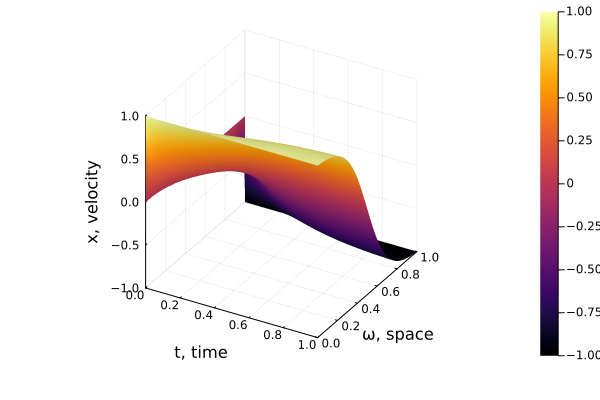

In [9]:
# Verify the training data
surface(burger.t, burger.x, Xtr_all[1], camera=(-50,30))
xlabel!("t, time")
ylabel!("ω, space")
zlabel!("x, velocity")

### Generate Test Data

In [6]:
# Reference input/boundary condition for 
if change_boundary_condition
    Utest = zeros(burger.Tdim - 1, 1)
else
    Utest = ones(burger.Tdim - 1, 1)
end

# Store values
Xtst = Array{Matrix{Real}}(undef, burger.Pdim)
op_fom_tst = Array{LnL.operators}(undef, burger.Pdim)

# Generate the viscosity coefficients for the test
μs = vcat([0.2, 0.4, 0.6, 0.8, 1.0], rand(Uniform(0.0,1.0),5,1))

println("[INFO] Generate Test Data")
@showprogress for i in 1:length(μs)
    μ = μs[i]
    
    # Generate the FOM system matrices 
    A, B, F = burger.generateABFmatrix(burger, μ)
    # C = ones(1, burger.Xdim) / burger.Xdim
    op_fom_tst[i] = LnL.operators(A=A, B=B, F=F)
    
    Xtst[i] = LnL.semiImplicitEuler(A, B, F, Utest, burger.t, burger.IC)
end

# Load the data so I can append to it
Data = load("data/epOpInf_data.jld2")

# Append new data to the data dictionary
Data["Xtst"] = Xtst
Data["op_fom_tst"] = op_fom_tst
Data["μ_rand"] = μs

# Save data
save("data/epOpInf_data.jld2", Data)

[INFO] Generate Test Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


### Obtain intrusive operators and non-constrained OpInf operators

In [7]:
# Store values
op_int = Array{LnL.operators}(undef, burger.Pdim)
op_nc_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
Data = load("data/epOpInf_data.jld2");

println("[INFO] Compute the intrusive operators and nc-OpInf operators")
for i in 1:length(burger.μs)
    Vrmax_::Matrix{Float64} = Data["Vrmax"][i]
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(Data["op_fom_tr"][i], Vrmax_, options)
    
    # Compute non-constrained OpInf
    op_nc_opinf[i] = LnL.inferOp(Data["Xtr"][i], Data["Utr"][i], Data["Ytr"][i], Vrmax_, Vrmax_' * Data["Rtr"][i], options, op_int[i])
    
    println("[DEBUG] Loop $(i) out of 10 completed...") 
end

# Save to data
Data["op_int"] = op_int
Data["op_nc_opinf"] = op_nc_opinf
save("data/epOpInf_data.jld2", Data)

[INFO] Compute the intrusive operators and nc-OpInf operators


┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP ~/.julia/packages/JuMP/AKvOr/src/operators.jl:270



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[DEBUG] Constraint        = Non-Constrained
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 3.355246344639576

[DEBUG] Loop 1 out of 10 completed...
[DEBUG] Constraint        = Non-Constrained
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 0.2025882938076939

[DEBUG] Loop 2 out of 10 completed...
[DEBUG] Constraint        = Non-Constrained
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[I

### Obtain operators for ephec-OpInf

In [5]:
# Switch optimization scheme
options.optimization = "EPHEC"
options.max_iter = 5000

# Store values
op_ephec_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
Data = load("data/epOpInf_data.jld2");

println("[INFO] Compute the ephec-OpInf operators")
for i in 1:length(burger.μs)
    Vrmax_::Matrix{Float64} = Data["Vrmax"][i]
    
    # Compute non-constrained OpInf (the initial guess is the non-constrained operator inference operators)
    op_ephec_opinf[i] = LnL.inferOp(Data["Xtr"][i], Data["Utr"][i], Data["Ytr"][i], Vrmax_, Vrmax_' * Data["Rtr"][i], options, Data["op_int"][i])
    
    println("[DEBUG] Loop $(i) out of 10 completed...") 
end

# Save to data
Data["op_ephec_opinf"] = op_ephec_opinf
save("data/epOpInf_data.jld2", Data)

[INFO] Compute the ephec-OpInf operators


┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP ~/.julia/packages/JuMP/AKvOr/src/operators.jl:270



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[DEBUG] Constraint        = Energy-Preserving Hard Equality Constraint
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 415.60071788449966

[DEBUG] Loop 1 out of 10 completed...
[DEBUG] Constraint        = Energy-Preserving Hard Equality Constraint
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 513.8578769625896

[DEBUG] Loop 2 out of 10 completed...
[DEBUG] Constraint        = Energy-Preserving Hard Equality Constr

### Obtain operators for epsic-OpInf

In [6]:
# Switch optimization scheme
options.optimization = "EPSIC"
options.ϵ_ep = 1
options.max_iter = 5000

# Store values
op_epsic_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
Data = load("data/epOpInf_data.jld2");

println("[INFO] Compute the epsic-OpInf operators")
for i in 1:length(burger.μs)
    Vrmax_::Matrix{Float64} = Data["Vrmax"][i]
    
    # Compute non-constrained OpInf (Give the initial guess the non-constrained operator inference operators)
    op_epsic_opinf[i] = LnL.inferOp(Data["Xtr"][i], Data["Utr"][i], Data["Ytr"][i], Vrmax_, Vrmax_' * Data["Rtr"][i], options, Data["op_int"][i])
    
    println("[DEBUG] Loop $(i) out of 10 completed...") 
end

# Save to data
Data["op_epsic_opinf"] = op_epsic_opinf
save("data/epOpInf_data.jld2", Data)

[INFO] Compute the epsic-OpInf operators


┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP ~/.julia/packages/JuMP/AKvOr/src/operators.jl:270



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[DEBUG] Constraint        = Energy-Preserving Soft Inequality Constraint
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 373.1077767393528

[DEBUG] Loop 1 out of 10 completed...
[DEBUG] Constraint        = Energy-Preserving Soft Inequality Constraint
[INFO] order              = 20
[INFO] termination_status = LOCALLY_SOLVED
[INFO] primal_status      = FEASIBLE_POINT
[INFO] objective_value    = 456.15202109112175

[DEBUG] Loop 2 out of 10 completed...
[DEBUG] Constraint        = Energy-Preserving Soft Inequality 

### Test & Analyze (Training Data)

In [6]:
function quadEnergyRate(X::Vector, F::Matrix)
    return X' * F * LnL.vech(X * X')
end

function quadEnergyRate(X::Matrix, F::Matrix)
    _, m = size(X)
    S = zeros(m,1)
    for i in 1:m
        S[i] = X[:,i]' * F * LnL.vech(X[:,i] * X[:,i]')
    end
    return S
end

quadEnergyRate (generic function with 2 methods)

In [50]:
# Projection error
train_proj_err = zeros(rmax - (rmin-1), burger.Pdim) 
# Relative state error
train_state_err = Dict(
    :int => zeros(rmax-rmin+1, burger.Pdim),
    :LS => zeros(rmax-rmin+1, burger.Pdim),
    # :nc_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    :ephec_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    # :epsic_OpInf => zeros(rmax-rmin+1, burger.Pdim)
)
# Energy 
train_En = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{VecOrMat{Float64}}(undef, burger.Pdim)
)
# Constraint Residual
train_CR = Dict(
    :int => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{Float64}(undef, burger.Pdim)
)
# Momentum
train_mmt = Dict(
    :int => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{Float64}(undef, burger.Pdim)
)
# Constraint Violation
train_CV = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{VecOrMat{Float64}}(undef, burger.Pdim)
)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    @info "Data loaded."
end

@info "Analyze the operators with training data..."
@showprogress for i in 1:length(burger.μs)
    op_LS = Data["op_LS"][i]
    op_int = Data["op_int"][i]
    # op_nc_opinf = Data["op_nc_opinf"][i]
    op_ephec_opinf = Data["op_ephec_opinf"][i]
    # op_epsic_opinf = Data["op_epsic_opinf"][i]
    
    Xtrain = Data["Xtr_all"][i]
    Vrmax_ = Data["Vrmax"][i]
    
    # Energy of the FOM
    train_En[:fom][i] = norm.(eachcol(Xtrain), 2)
    F_full = Data["op_fom_tr"][i].F
    train_CR[:fom][i], train_mmt[:fom][i] = LnL.constraintResidual(F_full, size(F_full, 1), options.which_quad_term)
    train_CV[:fom][i] = LnL.constraintViolation(Xtrain, F_full, options.which_quad_term)
    
    for (j,r) in enumerate(rmin:rmax)
        Vr = Vrmax_[:, 1:r]

        # Integrate the LS operator inference model
        Finf_extract_LS = LnL.extractF(op_LS.F, r)
        Xinf_LS = burger.semiImplicitEuler(op_LS.A[1:r, 1:r], Finf_extract_LS, burger.t, Vr' * burger.IC)

        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, r)
        Xint = burger.semiImplicitEuler(op_int.A[1:r, 1:r], Fint_extract, burger.t, Vr' * burger.IC)

        # Integrate the non-constrained operator inference model
        # Finf_extract_nc = LnL.extractF(op_nc_opinf.F, r)
        # Xinf_nc = burger.semiImplicitEuler(op_nc_opinf.A[1:r, 1:r], Finf_extract_nc, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving hard equality constraint operator inference model
        Finf_extract_ephec = LnL.extractF(op_ephec_opinf.F, r)
        Xinf_ephec = burger.semiImplicitEuler(op_ephec_opinf.A[1:r, 1:r], Finf_extract_ephec, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving soft inequality constraint operator inference model
        # Finf_extract_epsic = LnL.extractF(op_epsic_opinf.F, r)
        # Xinf_epsic = burger.semiImplicitEuler(op_epsic_opinf.A[1:r, 1:r], Finf_extract_epsic, burger.t, Vr' * burger.IC)
        
        # Compute errors
        train_proj_err[j, i] = LnL.compProjError(Xtrain, Vr)
        train_state_err[:LS][j, i] = LnL.compStateError(Xtrain, Xinf_LS, Vr)
        train_state_err[:int][j, i] = LnL.compStateError(Xtrain, Xint, Vr)
        # train_state_err[:nc_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_nc, Vr)
        train_state_err[:ephec_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_ephec, Vr)
        # train_state_err[:epsic_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_epsic, Vr)
        
        # Compute energy 
        train_En[:LS][j, i] = norm.(eachcol(Vr * Xinf_LS), 2)
        train_En[:int][j, i] = norm.(eachcol(Vr * Xint), 2)
        # train_En[:nc_OpInf][j, i] = norm.(eachcol(Vr * Xinf_nc), 2)
        train_En[:ephec_OpInf][j, i] = norm.(eachcol(Vr * Xinf_ephec), 2)
        # train_En[:epsic_OpInf][j, i] = norm.(eachcol(Vr * Xinf_epsic), 2)

        if i == 10 && r == rmax 
            CSV.write("data/s_rec.csv",  Tables.table(Vr * Xinf_ephec), writeheader=false)
        end
        
        # Compute the CR and momentum
        train_CR[:LS][j, i], train_mmt[:LS][j, i] =  LnL.constraintResidual(Finf_extract_LS, r, options.which_quad_term)
        train_CR[:int][j, i], train_mmt[:int][j, i] = LnL.constraintResidual(Fint_extract, r, options.which_quad_term)
        train_CR[:ephec_OpInf][j, i], train_mmt[:ephec_OpInf][j, i] = LnL.constraintResidual(Finf_extract_ephec, r, options.which_quad_term)
        # train_CR[:epsic_OpInf][j, i], train_mmt[:epsic_OpInf][j, i] = LnL.constraintResidual(Finf_extract_epsic, r, options.which_quad_term)

        # Compute constraint violations
        train_CV[:LS][j, i] = LnL.constraintViolation(Xinf_LS, Finf_extract_LS, options.which_quad_term)
        train_CV[:int][j, i] = LnL.constraintViolation(Xint, Fint_extract, options.which_quad_term)
        train_CV[:ephec_OpInf][j, i] = LnL.constraintViolation(Xinf_ephec, Finf_extract_ephec, options.which_quad_term)
        # train_CV[:epsic_OpInf][j, i] = LnL.constraintViolation(Xinf_epsic, Finf_extract_epsic, options.which_quad_term)
    end
end


# Save data
Data["train_proj_err"] = train_proj_err
Data["train_state_err"] = train_state_err
Data["train_En"] = train_En
Data["train_CR"] = train_CR
Data["train_mmt"] = train_mmt
Data["train_CV"] = train_CV
save(filename, Data)
;

[INFO] Analyze the operators with training data...


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


Dict{Symbol, Array{VecOrMat{Float64}}} with 5 entries:
  :int         => [[0.0; 74.6478; … ; 85.4871; 85.4896;;] [0.0; 73.8297; … ; 84…
  :ephec_OpInf => [[0.0; 1.77636e-15; … ; -5.32907e-15; 7.99361e-15;;] [0.0; -8…
  :nc_OpInf    => [[0.0; 90.0949; … ; 93.6513; 93.684;;] [0.0; 88.522; … ; 85.5…
  :epsic_OpInf => [[0.0; 28.8737; … ; 63.0708; 63.0379;;] [0.0; 28.6555; … ; 87…
  :fom         => [[0.0; 70.2899; … ; 85.2071; 85.2085;;], [0.0; 74.1779; … ; 8…

### Test and Analyze (Test Data)

In [36]:
# TODO: Compute energy for the reconstructed states with POD basis


test_proj_err = zeros(rmax - (rmin-1), burger.Pdim) 
test_state_err = Dict(
    :int => zeros(rmax-rmin+1, burger.Pdim),
    :nc_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    :ephec_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    :epsic_OpInf => zeros(rmax-rmin+1, burger.Pdim)
)
test_En = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :epsic_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), 10),
    :fom => Array{VecOrMat{Float64}}(undef, 10),
)
test_CR = Dict(
    :int => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :nc_OpInf => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :ephec_OpInf => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :epsic_OpInf => Array{Matrix{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{Matrix{Float64}}(undef, burger.Pdim)
)

Data = load("data/epOpInf_data.jld2")

DS = 100
Utest = ones(burger.Tdim - 1, 1);  
println("[INFO] Analyze the operators with testing data...")
@showprogress for i in 1:length(Data["μ_rand"])
    op_int = Data["op_int"][i]
    op_nc_opinf = Data["op_nc_opinf"][i]
    op_ephec_opinf = Data["op_ephec_opinf"][i]
    op_epsic_opinf = Data["op_epsic_opinf"][i]
    
    Xtest = Data["Xtst"][i]
    Vrmax_ = Data["Vrmax"][i]
    
    # Downsample
    Xtest = Xtest[:,1:DS:end]
    
    # Energy of the FOM
    test_En[:fom][i] = norm.(eachcol(Xtest), 2)
    Ffom::Matrix = Data["op_fom_tst"][i].F
    test_CR[:fom][i] = quadEnergyRate(Xtest, Ffom)
    
    for (j,r) in enumerate(rmin:rmax)
        Vr = Vrmax_[:, 1:r]

        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, r)
        Xint = LnL.semiImplicitEuler(op_int.A[1:r, 1:r], op_int.B[1:r, :], Fint_extract, Utest, burger.t, Vr' * burger.IC)

        # Integrate the non-constrained operator inference model
        Finf_extract_nc = LnL.extractF(op_nc_opinf.F, r)
        Xinf_nc = LnL.semiImplicitEuler(op_nc_opinf.A[1:r, 1:r], op_nc_opinf.B[1:r, :], Finf_extract_nc, Utest, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving hard equality constraint operator inference model
        Finf_extract_ephec = LnL.extractF(op_ephec_opinf.F, r)
        Xinf_ephec = LnL.semiImplicitEuler(op_ephec_opinf.A[1:r, 1:r], op_ephec_opinf.B[1:r, :], Finf_extract_ephec, Utest, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving soft inequality constraint operator inference model
        Finf_extract_epsic = LnL.extractF(op_epsic_opinf.F, r)
        Xinf_epsic = LnL.semiImplicitEuler(op_epsic_opinf.A[1:r, 1:r], op_epsic_opinf.B[1:r, :], Finf_extract_epsic, Utest, burger.t, Vr' * burger.IC)
        
        # Downsample
        Xint = Xint[:, 1:DS:end]
        Xinf_nc = Xinf_nc[:, 1:DS:end]
        Xinf_ephec = Xinf_ephec[:, 1:DS:end]
        Xinf_epsic = Xinf_epsic[:, 1:DS:end]
        
        # Compute errors
        test_proj_err[j, i] = LnL.compProjError(Xtest, Vr)
        test_state_err[:int][j, i] = LnL.compStateError(Xtest, Xint, Vr)
        test_state_err[:nc_OpInf][j, i] = LnL.compStateError(Xtest, Xinf_nc, Vr)
        test_state_err[:ephec_OpInf][j, i] = LnL.compStateError(Xtest, Xinf_ephec, Vr)
        test_state_err[:epsic_OpInf][j, i] = LnL.compStateError(Xtest, Xinf_epsic, Vr)
        
        # Compute energy 
        test_En[:int][j, i] = norm.(eachcol(Xint), 2)
        test_En[:nc_OpInf][j, i] = norm.(eachcol(Xinf_nc), 2)
        test_En[:ephec_OpInf][j, i] = norm.(eachcol(Xinf_ephec), 2)
        test_En[:epsic_OpInf][j, i] = norm.(eachcol(Xinf_epsic), 2)
        
        # Compute the CR
        test_CR[:int][j, i] = quadEnergyRate(Xint, Fint_extract)
        test_CR[:nc_OpInf][j, i] = quadEnergyRate(Xinf_nc, Finf_extract_nc)
        test_CR[:ephec_OpInf][j, i] = quadEnergyRate(Xinf_ephec, Finf_extract_ephec)
        test_CR[:epsic_OpInf][j, i] = quadEnergyRate(Xinf_epsic, Finf_extract_epsic)
    end
end

# Save data
Data["test_proj_err"] = test_proj_err
Data["test_state_err"] = test_state_err
Data["test_En"] = test_En
Data["test_CR"] = test_CR
save("data/epOpInf_data.jld2", Data)

[INFO] Analyze the operators with testing data...


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


### Results

In [5]:
Data = load("data/epOpInf_data.jld2");

#### Projection Error

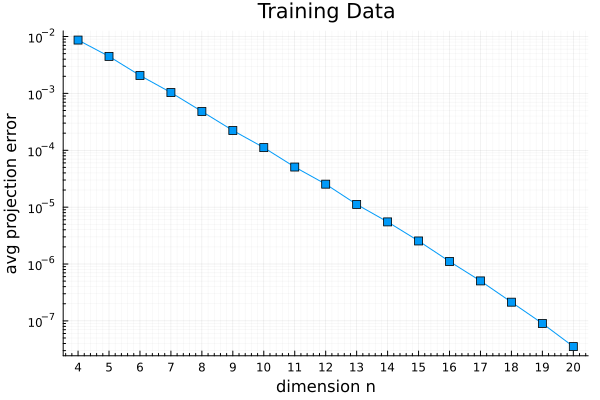

In [51]:
# Training data
mean_train_proj_err = mean(Data["train_proj_err"], dims=2)

plot(rmin:rmax, mean_train_proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(mean_train_proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")
title!("Training Data")

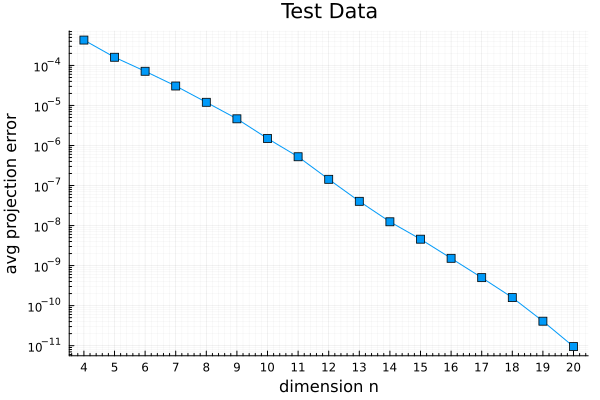

In [43]:
# Test data
mean_test_proj_err = mean(Data["test_proj_err"], dims=2)

plot(rmin:rmax, mean_test_proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(mean_test_proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")
title!("Test Data")

#### Mean relative state error

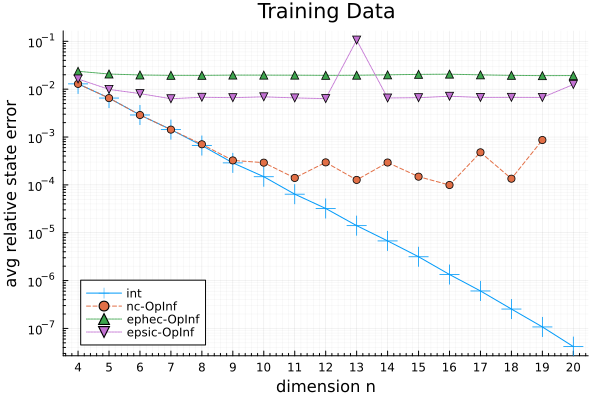

In [52]:
# Training data
mean_int_state_err = mean(Data["train_state_err"][:int], dims=2)
mean_nc_state_err = mean(Data["train_state_err"][:nc_OpInf], dims=2)
mean_ephec_state_err = nanmean(Data["train_state_err"][:ephec_OpInf], dims=2)
mean_epsic_state_err = nanmean(Data["train_state_err"][:epsic_OpInf], dims=2)

plot(rmin:rmax, mean_int_state_err, marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean_nc_state_err, marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean_ephec_state_err, marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean_epsic_state_err, marker=(:dtriangle), ls=:dot, label="epsic-OpInf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)
tmp = log10.(mean_int_state_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg relative state error")
title!("Training Data")

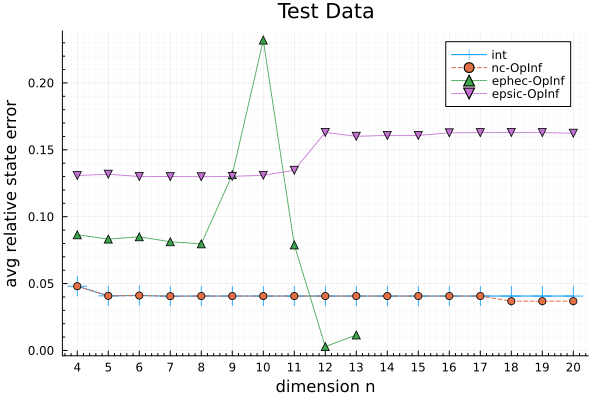

In [45]:
# Test data
mean_int_state_err = mean(Data["test_state_err"][:int], dims=2)
mean_nc_state_err = nanmean(Data["test_state_err"][:nc_OpInf], dims=2)
mean_ephec_state_err = nanmean(Data["test_state_err"][:ephec_OpInf], dims=2)
mean_epsic_state_err = nanmean(Data["test_state_err"][:epsic_OpInf], dims=2)

plot(rmin:rmax, mean_int_state_err, marker=(:cross, 10), label="int")
plot!(rmin:rmax, mean_nc_state_err, marker=(:circle), ls=:dash, label="nc-OpInf")
plot!(rmin:rmax, mean_ephec_state_err, marker=(:utriangle), ls=:dot, label="ephec-OpInf")
plot!(rmin:rmax, mean_epsic_state_err, marker=(:dtriangle), ls=:dot, label="epsic-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topright)
# plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:topright)
# tmp = log10.(mean_int_state_err)
# yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg relative state error")
title!("Test Data")

#### Total Energy

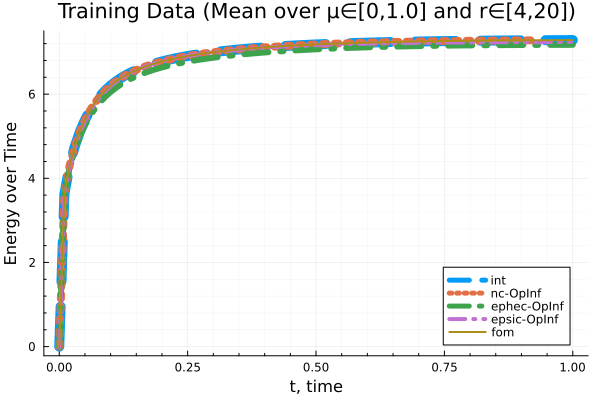

In [53]:
# Training data
DS = 100
mean_int_En_tr = mean(Data["train_En"][:int])
mean_nc_En_tr = mean(Data["train_En"][:nc_OpInf])
mean_ephec_En_tr = mean(Data["train_En"][:ephec_OpInf])
mean_epsic_En_tr = mean(Data["train_En"][:epsic_OpInf])
mean_fom_En_tr = mean(Data["train_En"][:fom])

plot(burger.t[1:DS:end], mean_int_En_tr, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tr, lw=8, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tr, lw=6, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_epsic_En_tr, lw=4, ls=:dashdotdot, label="epsic-OpInf")
plot!(burger.t[1:DS:end], mean_fom_En_tr, lw=2, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xlabel!("t, time")
ylabel!("Energy over Time")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

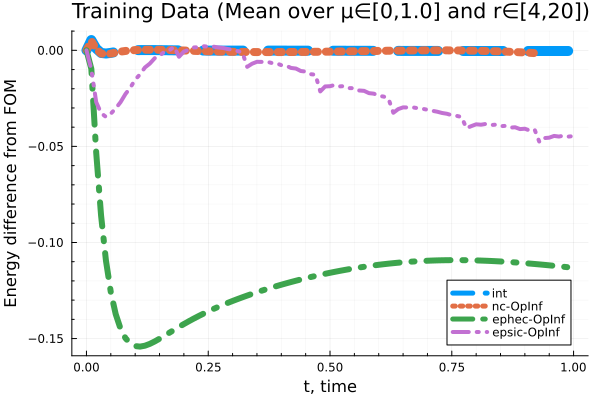

In [54]:
DS = 100
plot(burger.t[1:DS:end], mean_int_En_tr - mean_fom_En_tr, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tr - mean_fom_En_tr, lw=8, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tr - mean_fom_En_tr, lw=6, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_epsic_En_tr - mean_fom_En_tr, lw=4, ls=:dashdotdot, label="epsic-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xlabel!("t, time")
ylabel!("Energy difference from FOM")
title!("Training Data (Mean over μ∈[0,1.0] and r∈[4,20])")

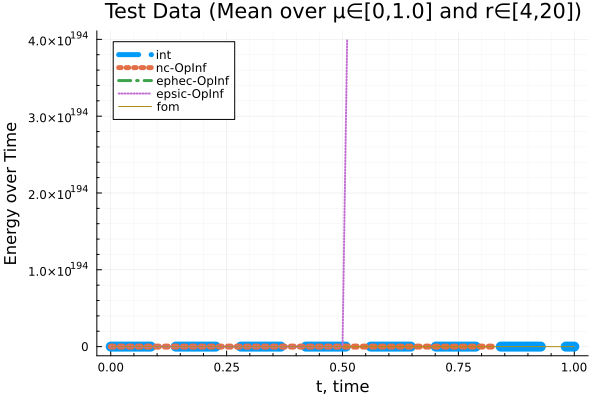

In [60]:
# Test data
DS = 100
mean_int_En_tst = mean(Data["test_En"][:int])
mean_nc_En_tst = mean(Data["test_En"][:nc_OpInf])
mean_ephec_En_tst = mean(Data["test_En"][:ephec_OpInf])
mean_epsic_En_tst = mean(Data["test_En"][:epsic_OpInf])
mean_fom_En_tst = mean(Data["test_En"][:fom])

plot(burger.t[1:DS:end], mean_int_En_tst, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tst, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tst, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_epsic_En_tst, lw=2, ls=:dot, label="epsic-OpInf")
plot!(burger.t[1:DS:end], mean_fom_En_tst, label="fom")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy over Time")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

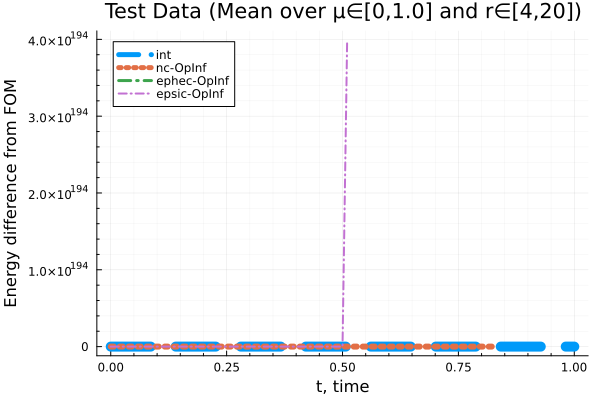

In [61]:
DS = 100
plot(burger.t[1:DS:end], mean_int_En_tst - mean_fom_En_tst, lw=10, ls=:dash, label="int")
plot!(burger.t[1:DS:end], mean_nc_En_tst - mean_fom_En_tst, lw=6, ls=:dot, label="nc-OpInf")
plot!(burger.t[1:DS:end], mean_ephec_En_tst - mean_fom_En_tst, lw=3, ls=:dashdot, label="ephec-OpInf")
plot!(burger.t[1:DS:end], mean_epsic_En_tst - mean_fom_En_tst, lw=2, ls=:dashdot, label="epsic-OpInf")
plot!(majorgrid=true, minorgrid=true, legend=:topleft)
xlabel!("t, time")
ylabel!("Energy difference from FOM")
title!("Test Data (Mean over μ∈[0,1.0] and r∈[4,20])")

#### Constraint Residual

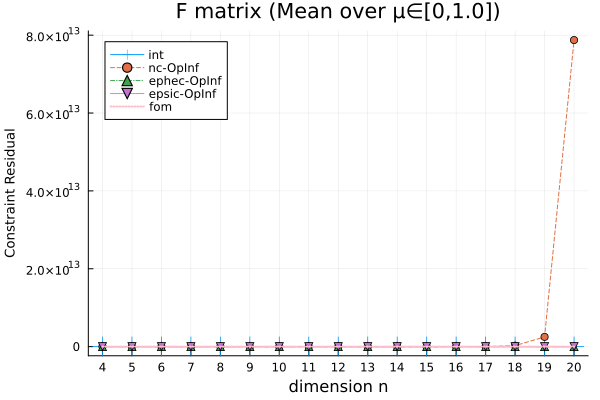

In [63]:
mean_LS_CR_tr = mean(Data["train_CR"][:LS], dims=2)
mean_int_CR_tr = mean(Data["train_CR"][:int], dims=2)
# mean_nc_CR_tr = mean(Data["train_CR"][:nc_OpInf], dims=2)
mean_ephec_CR_tr = mean(Data["train_CR"][:ephec_OpInf], dims=2)
# mean_epsic_CR_tr = mean(Data["train_CR"][:epsic_OpInf], dims=2)
mean_fom_CR_tr = mean(Data["train_CR"][:fom])

plot(rmin:rmax, mean_LS_CR_tr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(rmin:rmax, mean_int_CR_tr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
# plot!(rmin:rmax, mean_nc_CR_tr, marker=(:circle), ls=:dash, label=L"\mathrm{nc:opinf}")
plot!(rmin:rmax, mean_ephec_CR_tr, c=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ep}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_CR_tr, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}:\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
yticks!(10.0 .^ [-29, -18, -7, 4])
xticks!(1:15)
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

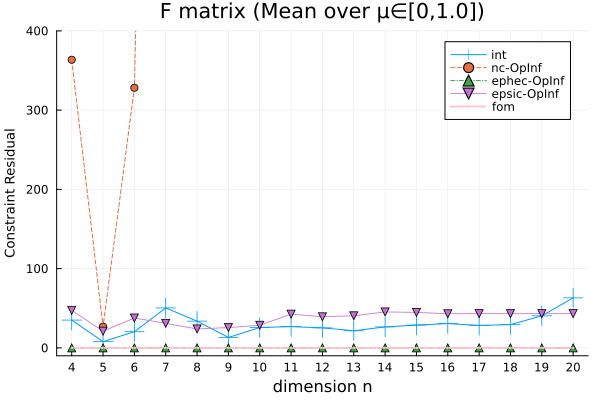

In [64]:
c1,c2,c3,c4,c5 = palette(:default)
plot(rmin:rmax, mean_int_CR_tr, c=c2, marker=(:cross, 10), label=L"\mathrm{int}")
plot!(rmin:rmax, mean_ephec_CR_tr, c=c4, marker=(:utriangle, 6), ls=:dot, label=L"\mathrm{ephec}:\mathrm{opinf}")
plot!(rmin:rmax, mean_epsic_CR_tr, c=c5, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}:\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xlabel!(L"\mathrm{dimension}~r")
ylabel!(L"\mathrm{constraint~residual~difference~from~intrusive~model}")
plot!(guidefontsize=10)

#### Constraint Violation

In [ ]:
# Training data
mean_LS_CV_tr    = abs.(mean(Data["train_CV"][:LS]))
mean_int_CV_tr   = abs.(mean(Data["train_CV"][:int]))
mean_nc_CV_tr    = abs.(mean(Data["train_CV"][:nc_OpInf]))
mean_ephec_CV_tr = abs.(mean(Data["train_CV"][:ephec_OpInf]))
mean_epsic_CV_tr = abs.(mean(Data["train_CV"][:epsic_OpInf]))
mean_fom_CV_tr   = abs.(mean(Data["train_CV"][:fom]))

plot(burger.t, mean_LS_CV_tr, lw=6, ls=:dash, label=L"\mathrm{LS}")
plot!(burger.t, mean_int_CV_tr, lw=8, ls=:dash, label=L"\mathrm{int}")
plot!(burger.t, mean_nc_CV_tr, lw=3, ls=:dot, label=L"\mathrm{nc:opinf}")
plot!(burger.t, mean_ephec_CV_tr, lw=3, ls=:dashdot, label=L"\mathrm{ephec:opinf}")
plot!(burger.t, mean_epsic_CV_tr, lw=3, ls=:dashdotdot, label=L"\mathrm{epsic:opinf}")
plot!(burger.t, mean_fom_CV_tr, lw=1, label=L"\mathrm{full}")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:right)
yticks!(10.0 .^ [-24, -21, -18, -15, -12, -9, -6, -3, 0])
xlabel!(L"\mathrm{time}~[s]")
ylabel!(L"\mathrm{absolute~values~of~constraint~violations}")
plot!(guidefontsize=10)